In [1]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [2]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")
train_labels = pd.read_csv("train_labels.csv",header=None)
test_labels = pd.read_csv("test_labels.csv",header=None)

In [3]:
print(train_data.shape,train_labels.shape,test_data.shape,test_labels.shape)

(65809, 155) (65809, 1) (43201, 155) (43201, 1)


In [70]:
train_data.head(3)
test_labels.head(3)

,0
0,0
1,0
2,0


In [4]:
print(Counter(train_labels[0]),Counter(test_labels[0]))

Counter({0: 65472, 2: 235, 1: 102}) Counter({0: 42969, 2: 189, 1: 43})


# Logistic Regression Baseline

In [30]:
from sklearn.metrics import roc_curve,roc_auc_score
def roc_plot(probs,labels,step):
    std_dev = np.std(probs)
    thresh = []
    st = min(probs)+std_dev
    while st < max(probs)-std_dev:
        thresh.append(st)
        st += step
    
    fpr,tpr,thr = roc_curve(labels,probs,labels)
    print(thr)
    
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    auc = roc_auc_score(labels, probs)
    print("AUC is ",auc)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

clf = LogisticRegression(random_state=121).fit(train_data.values,train_labels.values)

predictions = clf.predict(test_data)
log_probs = clf.predict_proba(test_data)
print(log_probs.shape,log_probs[0],log_probs[1])


/home/venugopal/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/venugopal/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(43201, 2) [0.5 0.5] [0.5 0.5]


In [35]:
tn, fp, fn, tp = confusion_matrix(test_labels,predictions).ravel()
print(" TP ",tp," TN ",tn," \n FP ",fp," FN ",fn)

 TP  0  TN  43156  
 FP  0  FN  45


# Dimensioanlity Reduction + Clustering

In [125]:

## Before - components only for train data

print("Original Shape ",train_data.shape)
pca = PCA(n_components=2,svd_solver="full")
X = pca.fit_transform(train_data.values)
print("Reduced ",X.shape)


Y = train_labels.values.reshape(-1)
print(Y.shape)


Original Shape  (109010, 155)
Reduced  (109010, 2)
(65809, 2) (43201, 2)
(65809,)


In [47]:
print(pca.components_.shape)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

(1, 155)
[1.]
[2.05574718e+34]


(65809, 3)
Counter({'blue': 65472, 'green': 235, 'red': 102})


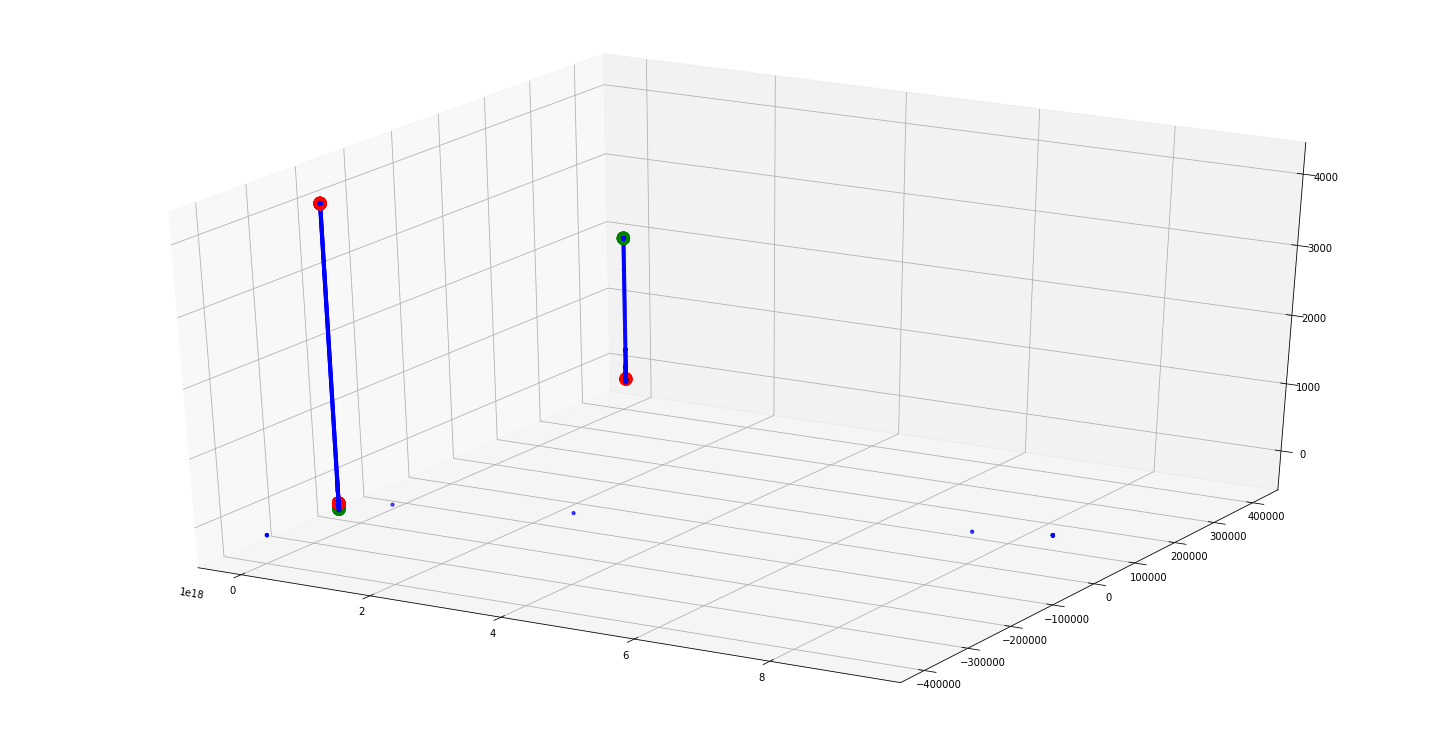

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

from collections import Counter
def plot_pca():
    plt.figure(figsize=(20,10))
    cp = ["blue","red","green"]
    s = [10,150,150]
    #anoms = X[np.where(train_labels.values > 0)]
    clr = [cp[int(Y[k])] for k in range(len(X))]
    sz = [s[int(Y[k])] for k in range(len(X))]
    print(Counter(clr))
    plt.scatter(X[:,0],X[:,1],color=clr,s=sz)
    
    plt.show()

def plot_3d():
    fig = plt.figure(figsize=(20,10))
    ax = Axes3D(fig)
    cp = ["blue","red","green"]
    s = [10,150,150]
    print(X.shape)
    clr = [cp[int(Y[k])] for k in range(len(X))]
    sz = [s[int(Y[k])] for k in range(len(X))]
    print(Counter(clr))
    ax.scatter(X[:,0],X[:,1],X[:,2],color=clr,s=sz)
    plt.show()
    
plot_3d()

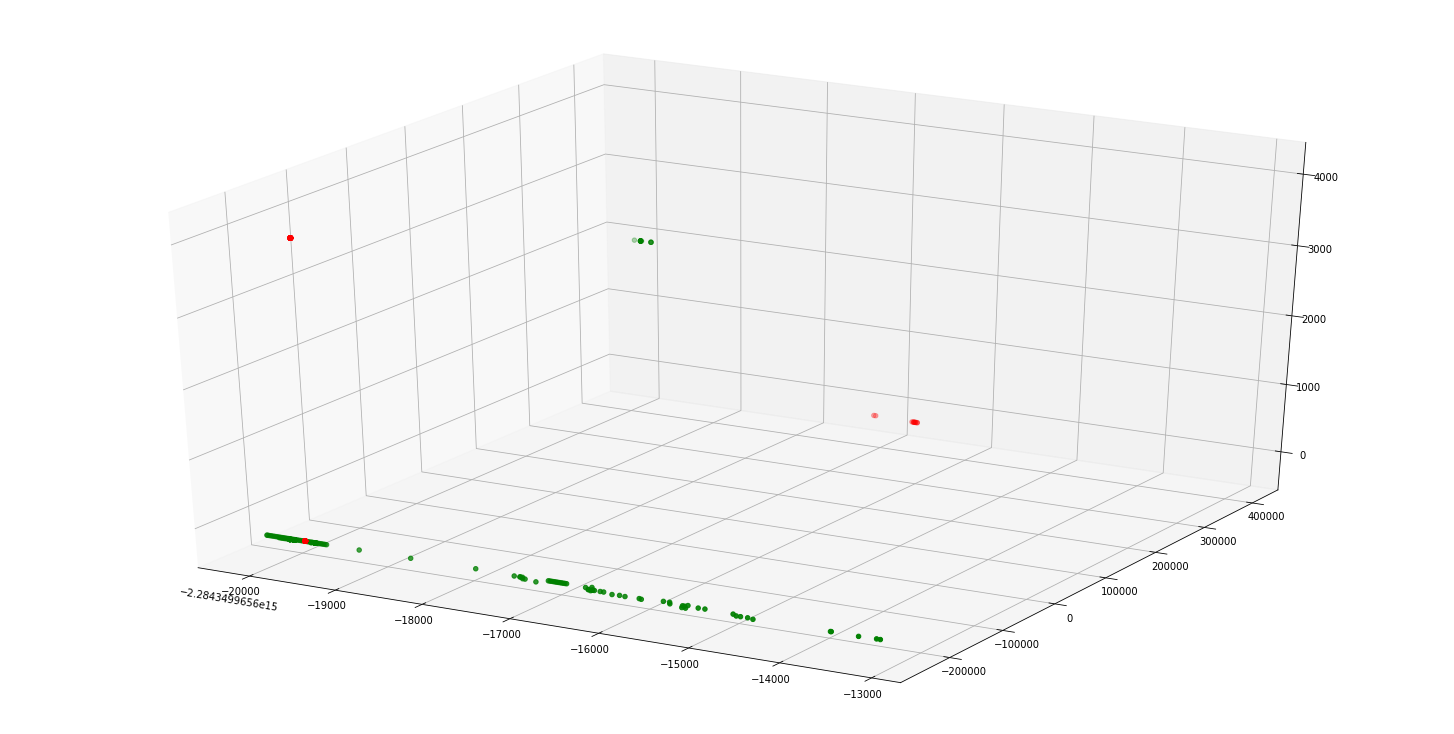

In [32]:
def plot_pca_anoms():
    plt.figure(figsize=(20,10))
    anoms_1 = X[np.where(Y==1)]
    anoms_2 = X[np.where(Y==2)]
    
    plt.scatter(anoms_1[:,0],anoms_1[:,1],color="red")
    plt.scatter(anoms_2[:,0],anoms_2[:,1],color="green")
    plt.show()

def plot_anoms_3d():
    fig = plt.figure(figsize=(20,10))
    ax = Axes3D(fig)
    anoms_1 = X[np.where(Y==1)]
    anoms_2 = X[np.where(Y==2)]
    
    ax.scatter(anoms_1[:,0],anoms_1[:,1],anoms_1[:,2],color="red")
    ax.scatter(anoms_2[:,0],anoms_2[:,1],anoms_2[:,2],color="green")
    plt.show()
    

plot_anoms_3d()

In [5]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adadelta, Adam

from keras.losses import mean_squared_error,mean_absolute_error, logcosh, categorical_crossentropy, sparse_categorical_crossentropy

from keras.initializers import RandomNormal, RandomUniform, glorot_normal

from keras.callbacks import TerminateOnNaN, LearningRateScheduler, EarlyStopping

cb1 = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=0, mode='auto', restore_best_weights=False)
cb2 = TerminateOnNaN()
cb = [cb1,cb2]

sgd = SGD(lr=0.01)
adadelta = Adadelta(lr=0.1, rho=0.95)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
adam_beta = [[0.9,0.999],[0.8,0.888],[0.7,0.777]]
more_optim = []
optim = [sgd,adadelta,adam]

lr = [0.1,0.01,0.001]
for l in lr:
    more_optim.append(SGD(lr=l))
    more_optim.append(Adadelta(lr=l))
    for b in adam_beta:
        more_optim.append(Adam(lr=l,beta_1=b[0],beta_2=b[1]))
    
print(more_optim)
loss = [logcosh]

init = ['glorot_uniform','random_uniform','random_normal']



print(train_data.shape)

print(np.count_nonzero(np.isnan(train_data)))
# reduce to 40 features
encoding_dim = 32

input_df = Input(shape=(train_data.shape[1],))
encoded_1 = Dense(encoding_dim, activation='relu',kernel_initializer=init[0])(input_df)
#encoded_2 = Dense(encoding_dim,activation='relu',kernel_initializer=init[0])(encoded_1)
#decoded_1 = Dense(64, activation='relu',kernel_initializer=init[0])(encoded_2)
decoded_2 = Dense(train_data.shape[1], activation='sigmoid')(encoded_1)

# encoder
autoencoder = Model(input_df, decoded_2)

# intermediate result
encoder = Model(input_df, encoded_1)

optimizer_list = []
for o in range(len(more_optim)):
    for ls in loss:
        opt = more_optim[o]
        print(" OPTIM ",opt,o, " LOSS ", ls)
        autoencoder.compile(optimizer=opt, loss=ls)

        history = autoencoder.fit(train_data, train_data,
                        epochs=150,
                        batch_size=10,
                        shuffle=True,
                        validation_split=0.2,callbacks=cb)



[<keras.optimizers.SGD object at 0x7ffa95a148d0>, <keras.optimizers.Adadelta object at 0x7ffa95a14ba8>, <keras.optimizers.Adam object at 0x7ffa95a14be0>, <keras.optimizers.Adam object at 0x7ffa95a149e8>, <keras.optimizers.Adam object at 0x7ffa95a14d68>, <keras.optimizers.SGD object at 0x7ffa959d5f98>, <keras.optimizers.Adadelta object at 0x7ffa959a3710>, <keras.optimizers.Adam object at 0x7ffa9590c908>, <keras.optimizers.Adam object at 0x7ffa95982320>, <keras.optimizers.Adam object at 0x7ffa95982ef0>, <keras.optimizers.SGD object at 0x7ffa9596a1d0>, <keras.optimizers.Adadelta object at 0x7ffa958d0908>, <keras.optimizers.Adam object at 0x7ffa958bbf28>, <keras.optimizers.Adam object at 0x7ffa9592fd30>, <keras.optimizers.Adam object at 0x7ffa9592f908>]
(65809, 155)
0
 OPTIM  <keras.optimizers.SGD object at 0x7ffa95a148d0> 0  LOSS  <function logcosh at 0x7ffa980b9510>
Train on 52647 samples, validate on 13162 samples
Epoch 1/150
52647/52647 [==============================] - 13s 242us/step

52647/52647 [==============================] - 7s 138us/step - loss: 18422247974021.8789 - val_loss: 4789.1534
Epoch 3/150
52647/52647 [==============================] - 7s 128us/step - loss: 18422247974022.8516 - val_loss: 4789.1534
Epoch 4/150
52647/52647 [==============================] - 7s 129us/step - loss: 18422247974022.5547 - val_loss: 4789.1534
 OPTIM  <keras.optimizers.Adam object at 0x7ffa958bbf28> 12  LOSS  <function logcosh at 0x7ffa980b9510>
Train on 52647 samples, validate on 13162 samples
Epoch 1/150
52647/52647 [==============================] - 7s 131us/step - loss: 18422247974021.1406 - val_loss: 4789.1534
Epoch 2/150
52647/52647 [==============================] - 7s 133us/step - loss: 18422247974022.0703 - val_loss: 4789.1534
Epoch 3/150
52647/52647 [==============================] - 7s 129us/step - loss: 18422247974021.6406 - val_loss: 4789.1534
Epoch 4/150
52647/52647 [==============================] - 7s 126us/step - loss: 18422247974022.0859 - val_loss: 4789.15

In [ ]:
# # Reduced dimesnions for the whole data

# total_X = np.concatenate([train_data,test_data])

# print("Original Shape ",total_X.shape)
# pca = PCA(n_components=2,svd_solver="full")
# total_X = pca.fit_transform(total_X)
# print("Reduced ",total_X.shape)

# train_x = total_X[:train_data.shape[0]]
# test_x = total_X[train_data.shape[0]:]
# print(train_x.shape,test_x.shape)

# LIGHT GBM on Classification setting

In [115]:
import lightgbm as lgbm

In [118]:
def convert_to_cat(labels):
    
    enc = LabelEncoder()
    enc_y = enc.fit_transform(labels)
    categorical_y = np_utils.to_categorical(enc_y)
    print(categorical_y.shape,categorical_y[:2])
    return categorical_y
n_classes = np.unique(test_labels.values)

In [119]:

test_X = pca.fit_transform(test_data.values)


lgb_train = lgbm.Dataset(X, train_labels)

parameters = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class':3,
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 63,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 70,
    'learning_rate': 0.05,
    'verbose': 1
}
model = lgbm.train(parameters, lgb_train, num_boost_round=150)

In [120]:
preds = model.predict(test_X,num_iteration=model.best_iteration)

print(np.asarray(preds).shape)
pred_c = np.asarray(preds).argmax(1)

print(Counter(test_labels[0]),Counter(pred_c))

(43201, 3)
Counter({0: 42969, 2: 189, 1: 43}) Counter({0: 43201})


In [121]:
from sklearn.metrics import roc_curve, auc

enc_labels = convert_to_cat(test_labels[0].values)
#print(enc_labels[:2])
fpr = {}
tpr = {}
roc = {}
for i in n_classes:
    fpr[i],tpr[i],_ = roc_curve(enc_labels[:,i],preds[:,i])
    roc[i] = auc(fpr[i],tpr[i])
    
    
print(roc)

(43201, 3) [[1. 0. 0.]
 [1. 0. 0.]]
{0: 0.5077473154262776, 1: 0.49012929236757957, 2: 0.507247085469442}


In [122]:
cm = confusion_matrix(test_labels[0],pred_c,labels=[0,1,2])
print(cm)
acc = (sum([cm[i][i] for i in range(len(cm))])/np.sum(cm))*100
print(acc)

[[42969     0     0]
 [   43     0     0]
 [  189     0     0]]
99.4629753940881
